In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

all the necessary libraries

In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [ ]:
# our dataset is in cocoformat, we will need pypcoco tools
from pycocotools.coco import COCO

In [ ]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2


We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

Dataset
This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [ ]:
class HelmetDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path = r"/content/drive/MyDrive/Colab Notebooks/data"

In [ ]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=10.12s)
creating index...
index created!


{0: {'id': 0, 'name': 'rider-helmet-bike', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'With Helmet', 'supercategory': 'rider-helmet-bike'},
 2: {'id': 2, 'name': 'Without Helmet', 'supercategory': 'rider-helmet-bike'}}

 list of classes

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['rider-helmet-bike', 'With Helmet', 'Without Helmet']

In [ ]:
len(classes)

3

In [ ]:
train_dataset = HelmetDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


This is a sample image and its bounding boxes

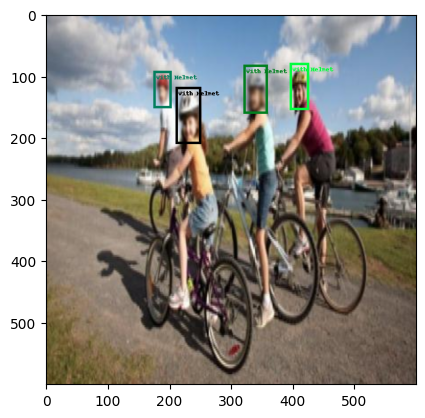

In [ ]:
# Lets view a sample
sample = train_dataset[867]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

1182

Model
Our model is FasterRCNN with a backbone of MobileNetV3-Large. We need to change the output layers because we have just 6 classes but this model was trained on 90 classes.

In [ ]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:01<00:00, 65.6MB/s]


create batches of data that can be easily pass into the model

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.5 MB/s eta 0:00:00


In [ ]:
import os
import sys
import dill

def save_object(file_path: str, obj: object) -> None:
    logging.info("Entered the save_object method of utils")

    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, "wb") as file_obj:
        dill.dump(obj, file_obj)

    logging.info("Exited the save_object method of utils")



def load_object(file_path: str) -> object:
    logging.info("Entered the load_object method of utils")


    with open(file_path, "rb") as file_obj:
        obj = dill.load(file_obj)

    logging.info("Exited the load_object method of utils")

    return obj

The following blocks ensures that the model can take in the data and that it will not crash during training

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
model = model.to(device)

Optimizer
Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

In [ ]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)


In [ ]:
import sys

Training:

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss,the accuracy  automatically and show the plot.

In [ ]:
import matplotlib.pyplot as plt

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Plot the loss
    plt.figure(figsize=(10, 5))
    plt.plot(all_losses, label='Total Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(f'Training Loss - Epoch {epoch}')
    plt.legend()
    plt.show()

    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))


In [ ]:
num_epochs=25


for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

 86%|████████▌ | 254/296 [03:30<00:49,  1.19s/it]

Trying on sample Images
This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [ ]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = HelmetDetection(root=dataset_path, split="test", transforms=get_transforms(False))

In [ ]:
len(test_dataset)

In [ ]:
img, _ = test_dataset[50]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [ ]:
prediction

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

**OpenCV**

In [ ]:

video_path ="/content/drive/MyDrive/helmeto.mp4"

In [ ]:
!pip install opencv-python-headless


In [ ]:
# Fonction pour appliquer le modèle de détection d'objets sur les images
import torch
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Fonction pour extraire les images de la vidéo
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    return frames

In [ ]:
# Extraction des frames
frames = extract_frames(video_path)

In [ ]:
number_of_frames = len(frames)
print("Nombre de frames dans la vidéo :", number_of_frames)

In [ ]:
import torch
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes

def process_frames(frames, model, device, classes, threshold=0.8):
    processed_frames = []
    model.to(device)
    model.eval()

    for frame in frames:
        tensor_img = F.to_tensor(frame).to(device)

        with torch.no_grad():
            prediction = model([tensor_img])
            pred = prediction[0]

        img_int = torch.tensor(tensor_img * 255, dtype=torch.uint8)

        # Filtrer les prédictions pour n'inclure que les classes connues
        known_boxes = []
        known_labels = []
        for score, label, box in zip(pred['scores'], pred['labels'], pred['boxes']):
            if score > threshold and label.item() in classes:
                known_boxes.append(box)
                known_labels.append(classes[label.item()])

        # Dessiner les boîtes englobantes pour les classes connues
        if known_boxes:
            img_with_boxes = draw_bounding_boxes(
                img_int,
                torch.stack(known_boxes),
                known_labels,
                width=4
            ).permute(1, 2, 0).numpy()
        else:
            img_with_boxes = img_int.permute(1, 2, 0).numpy()

        processed_frames.append(img_with_boxes)

    return processed_frames


In [ ]:
# Assurez-vous que votre tensor est sur le CPU
img_with_boxes = img_int.cpu().permute(1, 2, 0).numpy()


In [ ]:

classes = {0: 'rider-helmet-bike', 1: 'With Helmet', 2: 'Without Helmet'}

processed_frames = process_frames(frames, model, device, classes)


In [ ]:
# Fonction pour créer la vidéo à partir des frames
def create_video(frames, output_path='output.mp4', fps=30):
    height, width, layers = frames[0].shape
    size = (width, height)
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    for frame in frames:
        out.write(frame)

    out.release()

In [ ]:

# Création de la vidéo traitée
create_video(processed_frames)

# Affichez la vidéo dans Colab
Video("output.mp4")
